# Que 3. How many fatal log entries that occurred on a Monday resulted from a” machine check interrupt”?

basic steps followed to answer the questions were reffered from
https://spark.apache.org/docs/latest/api/python/getting_started/quickstart_df.html

In [1]:
#importing necessary libraries and datatypes

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DateType, TimestampType, IntegerType
from pyspark.sql.functions import *
import time
import matplotlib.pyplot as plt
import pandas as pd

#setting up a spark session

session = SparkSession.builder.appName("BGLlog").getOrCreate()

23/08/07 15:09:00 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
# start time of the program
start_program_time= time.time()

# Schema Design

In [3]:
# defined the schema for the BGL log data

BGL_schema = StructType([

    StructField("AlertFlag", StringType(),True),
    
    # first Timestamp is assigned to IntegerType datatype and later to TimestampType datatype, 
    # as initializing Timestamp to "TimestampType" datatype in the beginning was not possible
    StructField("Timestamp", IntegerType(),True), 

    StructField("Date", StringType(),True),

    StructField("Node", StringType(),True),

    StructField("date_and_time", TimestampType(),True),

    StructField("Node_Rep", StringType(),True),

    StructField("Message_Type", StringType(),True),

    StructField("SysComp", StringType(),True),

    StructField("Level", StringType(),True),

    StructField("Message_Content", StringType(),True)

])

In [4]:
# read the BGL log data from the CSV file with the specified schema (i.e. BGL_schema) 
# and date/timestamp formats are specified

BGL_df=session.read.csv(
    "BGLnew.log",
    schema = BGL_schema,
    dateFormat = "yyyy.MM.dd", 
    timestampFormat = "yyyy-MM-dd-HH.mm.ss.SSSSSS", 
    )

In [5]:
# cast the Timestamp coloumn to proper TimestampType 

BGL_df = BGL_df.withColumn("Timestamp", BGL_df["Timestamp"].cast(TimestampType()))

In [6]:
# print the schema to confirm the schema update of the Dataframe

BGL_df.printSchema()

root
 |-- AlertFlag: string (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- Date: string (nullable = true)
 |-- Node: string (nullable = true)
 |-- date_and_time: timestamp (nullable = true)
 |-- Node_Rep: string (nullable = true)
 |-- Message_Type: string (nullable = true)
 |-- SysComp: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Message_Content: string (nullable = true)



# Transformation on BGL dataframe

In [7]:
# filter the BGL dataframe to get rows with FATAL log from coloumn Level, 
# Monday from coloumn date_and_time, and containing "machine check interrupt" in the coloumn Message_Content

fatal_machine_check_entries = BGL_df.filter((col("Level") == "FATAL") & 
                                        (dayofweek(col("date_and_time")) == 2) &  # here Monday is represented as 2
                                        (col("Message_Content").contains("machine check interrupt")))

In [8]:
# filter the dataframe to remove rows where the "Node" column is either "NULL" or "UNKNOWN_LOCATION"
filtered_df = fatal_machine_check_entries.filter((col("Node") != "NULL") & (col("Node") != "UNKNOWN_LOCATION"))

# Action on the filtered dataframe

In [9]:
# group the dataframe by "Node" and count the occurrences of each node
node_frequency = filtered_df.groupBy("Node").count()

In [10]:
# order the nodes by the count of occurrences in descending order and get the top 5 nodes
top_5_nodes = node_frequency.orderBy(col("count").desc()).limit(5)

In [11]:
# convert the result to a Pandas dataframe for plotting
top_5_nodes_pandas = top_5_nodes.toPandas()

In [12]:
# count the number of fatal log entries on Mondays resulting from a machine check interrupt

num_fatal_machine_check_entries = fatal_machine_check_entries.count()

In [13]:
# print the result

print("Number of fatal log entries on Monday resulting from a machine check interrupt:", num_fatal_machine_check_entries)

Number of fatal log entries on Monday resulting from a machine check interrupt: 38


basic steps followed to visualize the further analysis on the nodes were reffered from https://sparkbyexamples.com/pandas/plot-the-dataframe-in-a-bar-in-pandas/

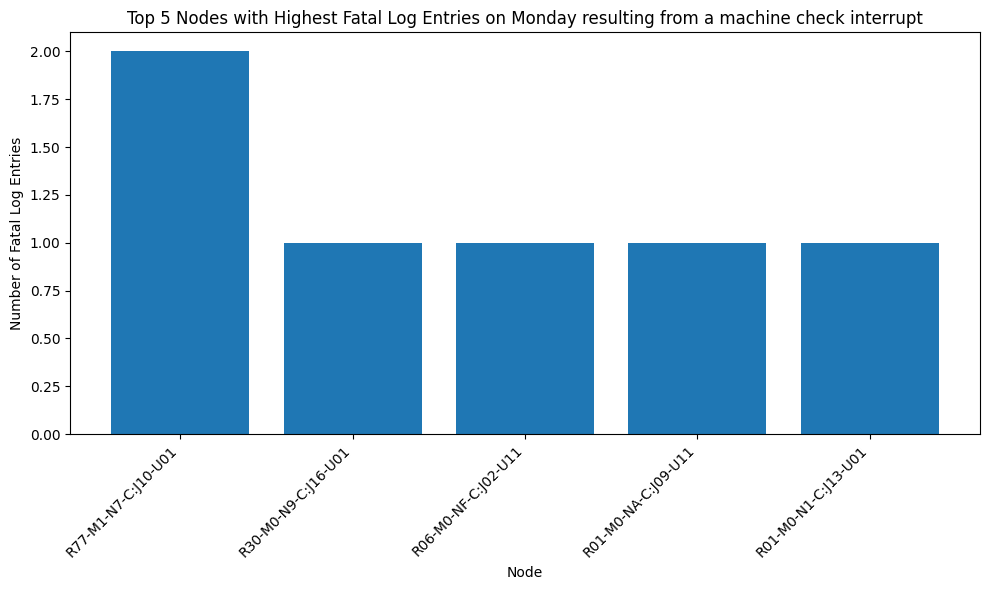

In [14]:
# plot the graph for the top 20 nodes that resulted in 
plt.figure(figsize=(10, 6))
plt.bar(top_5_nodes_pandas["Node"], top_5_nodes_pandas["count"])
plt.xlabel("Node")
plt.ylabel("Number of Fatal Log Entries")
plt.title("Top 5 Nodes with Highest Fatal Log Entries on Monday resulting from a machine check interrupt")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

The above bar graph gives a visual analysis on the nodes, where R77-M1-N7-C:J10-U01 occured twice on Monday.

# Execution Time of the Program

In [15]:
# end time of the program
end_program_time= time.time()

# calculate executation time
end_program_time-start_program_time

10.055001258850098